In [1]:
# import dependencies
import os
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub
import matplotlib.pyplot as plt

print(tf.__version__)

2.5.0


## LOAD DATASET

In [2]:
IMAGE_SIZE = 224
DATA_DIR = "./dataset/*/camera/*"
BATCH_SIZE = 32
SHUFFLE_BUFFER = 1000

list_ds = tf.data.Dataset.list_files(DATA_DIR, shuffle=False)
list_ds = list_ds.shuffle(SHUFFLE_BUFFER, reshuffle_each_iteration=False)

In [3]:
for f in list_ds.take(5):
    print(f.numpy())

b'./dataset/oreo/camera/40.jpg'
b'./dataset/oreo/camera/177.jpg'
b'./dataset/indomie/camera/50.jpg'
b'./dataset/aqua/camera/20210515_154009.jpg'
b'./dataset/aqua/camera/20210515_152413.jpg'


In [4]:
class_names = ['aqua', 'indomie', 'oreo', 'ultra-milk']

In [5]:
train_size = 900
val_size = 150
test_size = 150

train_ds = list_ds.take(train_size)
test_ds = list_ds.skip(train_size)
val_ds = test_ds.skip(val_size)
test_ds = test_ds.take(test_size)

In [6]:
print(tf.data.experimental.cardinality(list_ds).numpy())
print(tf.data.experimental.cardinality(train_ds).numpy())
print(tf.data.experimental.cardinality(val_ds).numpy())
print(tf.data.experimental.cardinality(test_ds).numpy())

1200
900
150
150


In [7]:
def get_label(file_path):
    # convert the path to a list of path components
    parts = tf.strings.split(file_path, os.path.sep)
    # The second to last is the class-directory
    one_hot = parts[-3] == class_names
    # Integer encode the label
    return tf.argmax(one_hot)

def decode_img(img):
    # convert the compressed string to a 3D uint8 tensor
    img = tf.image.decode_jpeg(img, channels=3)
    #img = tf.image.convert_image_dtype(image, tf.float32)
    # resize the image to the desired size
    return tf.image.resize(img, [IMAGE_SIZE, IMAGE_SIZE])

def process_path(file_path):
    label = get_label(file_path)
    # load the raw data from the file as a string
    img = tf.io.read_file(file_path)
    img = decode_img(img)
    return img, label

In [8]:
# Set `num_parallel_calls` so multiple images are loaded/processed in parallel.
train_ds = train_ds.map(process_path)
val_ds = val_ds.map(process_path)
test_ds = test_ds.map(process_path)

In [9]:
# shuffle and batch
def configure_for_performance(ds):
    #ds = ds.cache()
    ds = ds.shuffle(SHUFFLE_BUFFER)
    ds = ds.batch(BATCH_SIZE)
    #ds = ds.prefetch(buffer_size=AUTOTUNE)
    return ds

train_ds = configure_for_performance(train_ds)
val_ds = configure_for_performance(val_ds)
test_ds = configure_for_performance(test_ds)

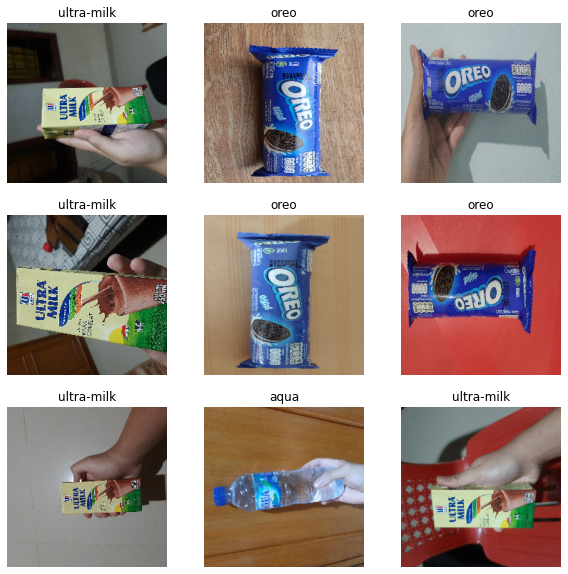

In [10]:
image_batch, label_batch = next(iter(train_ds))
#ds_iter = iter(train_ds)

plt.figure(figsize=(10, 10))
for i in range(9):
    #image_batch, label_batch = next(ds_iter)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image_batch[i].numpy().astype("uint8"))
    label = label_batch[i]
    plt.title(class_names[label])
    plt.axis("off")

## IMPORT PRE-TRAINED MODEL
Here we'll use MobileNet V2

In [11]:
MODULE_HANDLE = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4"
feature_extractor = hub.KerasLayer(MODULE_HANDLE, input_shape=(224, 224, 3), trainable=False)

## BUILD MODEL

In [12]:
model = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.Rescaling(1./255),
    feature_extractor,
    tf.keras.layers.Dense(len(class_names), activation='softmax')
])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

## TRAIN MODEL

In [13]:
EPOCHS = 1

history = model.fit(train_ds, epochs=EPOCHS, validation_data=val_ds)

29/29 [==============================] - 44s 799ms/step - loss: 0.4745 - accuracy: 0.8489 - val_loss: 0.0587 - val_accuracy: 1.0000


## PERFORMANCE TEST

In [14]:
eval_results = model.evaluate(test_ds)

for metric, value in zip(model.metrics_names, eval_results):
    print(metric + ': {:.4}'.format(value))

5/5 [==============================] - 6s 515ms/step - loss: 0.0552 - accuracy: 1.0000
loss: 0.05518
accuracy: 1.0
